# Hypothesis 2: Leisure vs Business Travel Market Analysis

In [ ]:
import pandas as pd
import numpy as np

# Step 0 - Environment preparation

# Connect with google drive (for Colab)
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


DUAL-DIMENSIONAL AVIATION ANALYSIS (LEISURE HYPOTHESIS)
TPI (Travel Purpose) vs Route Volume Categories
DUAL-DIMENSION ANALYSIS (REVERSED HYPOTHESIS): TPI vs ROUTE VOLUME CATEGORIES
Dataset loaded: 815,633 records
Years available: [2018, 2019, 2023, 2024]
TPI availability: 815,633 records (100.0%)
TPI range: 0.00 - 100.00

Using fixed TPI thresholds: Leisure ≤ 33, Mixed 34–65, Business ≥ 66

Time period data:
Pre-COVID (2018-2019): 404,657 records
Post-COVID (2023-2024): 410,976 records

DUAL-DIMENSION CLASSIFICATION SYSTEM:
TPI Categories: Leisure (≤33), Mixed (34-65), Business (≥66)
Volume Categories:
  Low Volume: <1,000 passengers
  Standard: 1,000-5,000 passengers
  Major: 5,000-10,000 passengers
  Highest: ≥10,000 passengers

EXECUTING DUAL-DIMENSIONAL ANALYSIS PIPELINE

DIMENSIONAL OVERVIEW ANALYSIS

PRE-COVID DATA STRUCTURE:
  ↳ saved: dimensional_overview_precovid_tpi_summary.csv
  ↳ saved: dimensional_overview_precovid_volume_summary.csv

TPI Summary:
TPI_CATEGORY  routes    

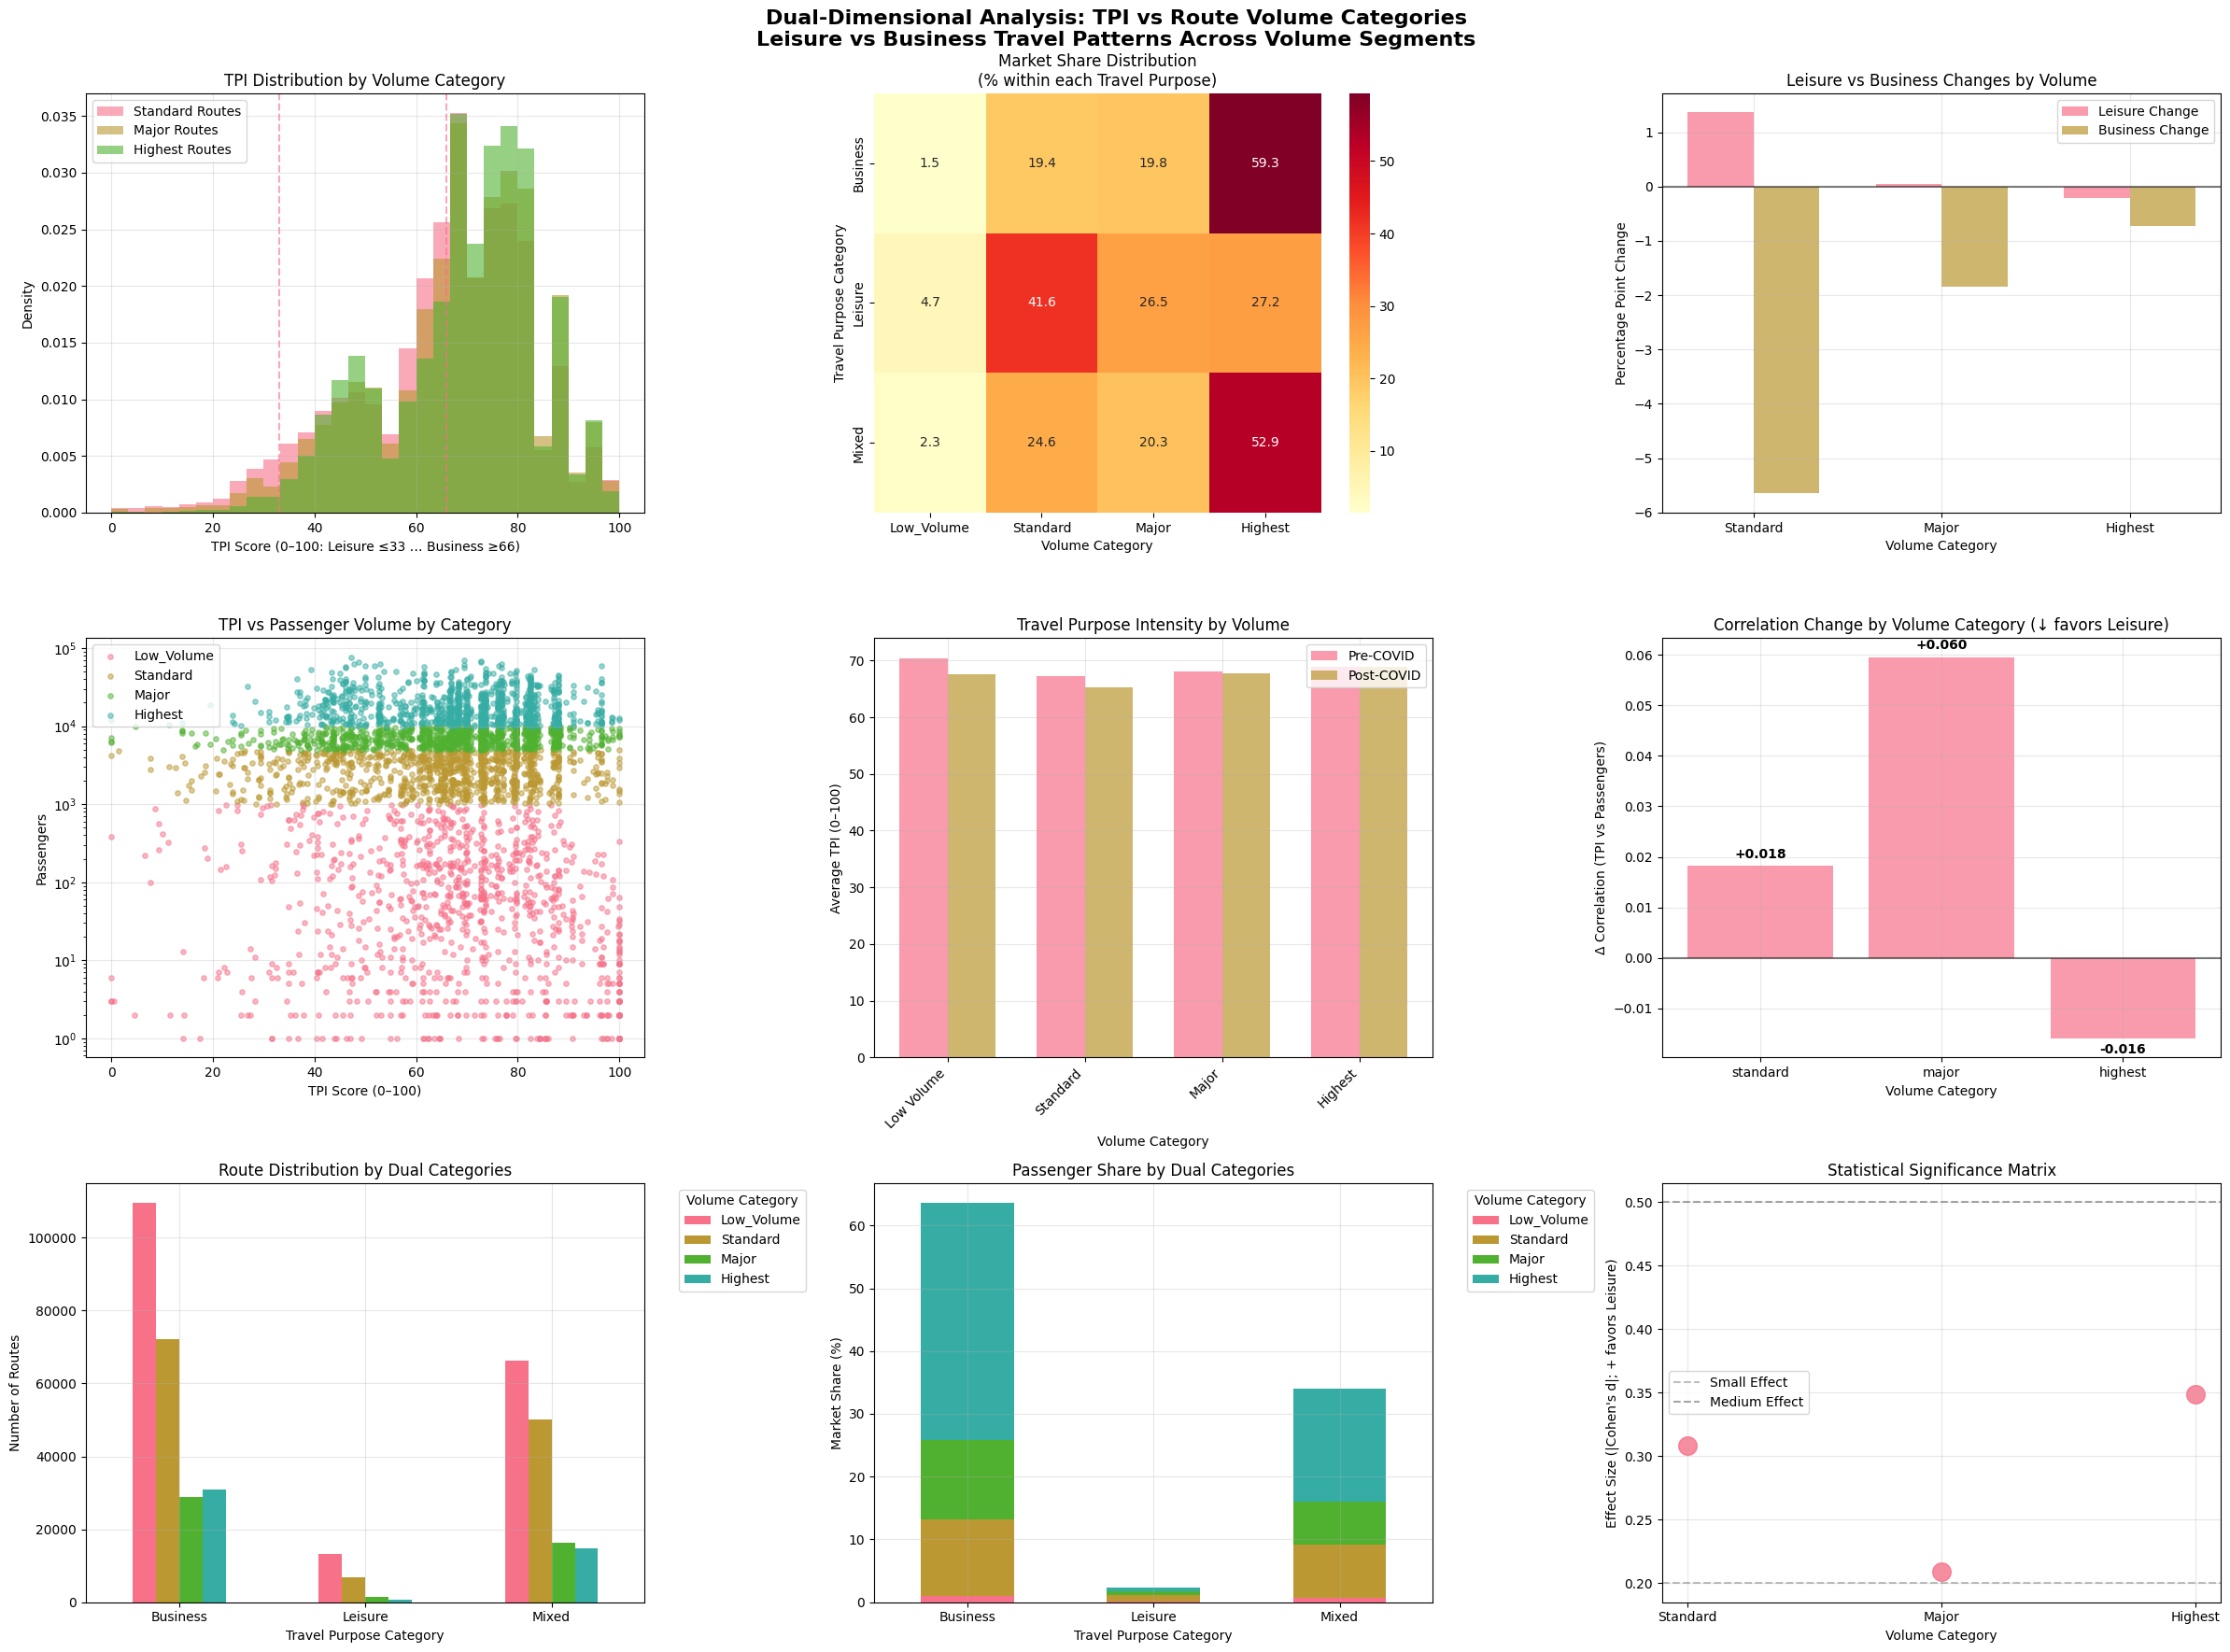

Visualizations saved as 'dual_dimensional_analysis_leisure.png'

HYPOTHESIS TESTING SUMMARY - DUAL DIMENSIONAL ANALYSIS (Leisure Hypothesis)
HYPOTHESIS 2 (Reversed): Leisure Beats Business in the New Economy

STANDARD ROUTES:
   Leisure travel change: +1.4 percentage points
   Business travel change: -5.7 percentage points
   TPI correlation change: +0.0182 (↓ favors Leisure)
   Hypothesis support: MODERATE
   Statistical significance: SIGNIFICANT (p = 0.0000) — Business ≥ Leisure
   Effect size: MEDIUM (Cohen's d = -0.3080; + favors Leisure)

MAJOR ROUTES:
   Leisure travel change: +0.1 percentage points
   Business travel change: -1.8 percentage points
   TPI correlation change: +0.0595 (↓ favors Leisure)
   Hypothesis support: MODERATE
   Statistical significance: SIGNIFICANT (p = 0.0000) — Business ≥ Leisure
   Effect size: MEDIUM (Cohen's d = -0.2088; + favors Leisure)

HIGHEST ROUTES:
   Leisure travel change: -0.2 percentage points
   Business travel change: -0.7 percentage poin

In [ ]:
"""
Post-COVID Aviation Pattern Research: Hypothesis 2 (Reversed) Analysis
Leisure Beats Business in the New Economy

Two-dimensional analysis: Travel Purpose Indicator (TPI) vs Route Volume Categories
Clean, organized code with comprehensive statistical testing

Author: Research Team
Date: August 2025
"""

import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, ttest_ind, f_oneway, chi2_contingency

warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette('husl')


# ----------------------- utilities -----------------------

def safe_correlation(data1, data2, method='pearson'):
    """Safely calculate correlation with error handling"""
    try:
        valid_mask = ~(pd.isna(data1) | pd.isna(data2))
        clean_data1 = data1[valid_mask]
        clean_data2 = data2[valid_mask]

        if len(clean_data1) < 3:
            return 0.0, 1.0

        if method == 'pearson':
            return pearsonr(clean_data1, clean_data2)
        elif method == 'spearman':
            return spearmanr(clean_data1, clean_data2)
        else:
            return pearsonr(clean_data1, clean_data2)
    except Exception as e:
        print(f"Correlation error: {str(e)}")
        return 0.0, 1.0


def safe_sample(data, sample_size, random_state=42):
    """Safely sample data without exceeding available observations"""
    if len(data) == 0:
        return data
    actual_sample_size = min(sample_size, len(data))
    return data.sample(actual_sample_size, random_state=random_state) if actual_sample_size < len(data) else data


# ----------------------- analyzer -----------------------

class DualDimensionAnalyzer:
    """
    Two-dimensional analyzer: TPI (Travel Purpose) vs Route Volume Categories
    Tests leisure vs business dominance across different route volume segments
    """

    def __init__(self, data_path, output_dir=None):
        self.data_path = Path(data_path)
        self.df = None
        self.pre_covid_data = None
        self.post_covid_data = None
        self.results = {}
        self.pre_covid_years = [2018, 2019]
        self.post_covid_years = [2023, 2024]

        # Route volume thresholds
        self.volume_thresholds = {
            'standard': 1000,      # Standard routes: 1K+ passengers
            'major': 5000,         # Major routes: 5K+ passengers
            'highest': 10000       # Highest-volume: 10K+ passengers
        }

        # Fixed TPI thresholds (0–100 scale)
        self.tpi_leisure_max = 33.0      # Leisure: TPI <= 33
        self.tpi_business_min = 66.0     # Business: TPI >= 66

        # Output folder
        self.outdir = Path(output_dir) if output_dir else (self.data_path.parent / "hyp2_outputs")
        self.outdir.mkdir(parents=True, exist_ok=True)

    # ------------- helpers -------------

    def _save(self, df: pd.DataFrame, filename: str):
        """Save dataframe to outputs folder"""
        fp = self.outdir / filename
        df.to_csv(fp, index=False)
        print(f"  ↳ saved: {fp.name}")

    def _mode_or_nan(self, series):
        m = series.mode()
        return m.iloc[0] if not m.empty else np.nan

    # ------------- pipeline steps -------------

    def load_and_prepare_data(self):
        """Load and prepare dataset with dual-dimension classification"""
        print("DUAL-DIMENSION ANALYSIS (REVERSED HYPOTHESIS): TPI vs ROUTE VOLUME CATEGORIES")
        print("=" * 80)

        try:
            self.df = pd.read_csv(self.data_path)

            # Coerce numeric columns
            for col in ['YEAR', 'PASSENGERS', 'TPI', 'DISTANCE']:
                if col in self.df.columns:
                    self.df[col] = pd.to_numeric(self.df[col], errors='coerce')

            print(f"Dataset loaded: {len(self.df):,} records")
            years = sorted(self.df['YEAR'].dropna().astype(int).unique().tolist())
            print(f"Years available: {years}")

            # Basic data quality
            tpi_available = self.df['TPI'].notna().sum()
            tpi_pct = (tpi_available / len(self.df)) * 100 if len(self.df) else 0.0
            print(f"TPI availability: {tpi_available:,} records ({tpi_pct:.1f}%)")
            if self.df['TPI'].notna().any():
                print(f"TPI range: {self.df['TPI'].min():.2f} - {self.df['TPI'].max():.2f}")
            else:
                print("TPI range: N/A")

            # Announce fixed thresholds
            print(
                f"\nUsing fixed TPI thresholds: Leisure ≤ {int(self.tpi_leisure_max)}, "
                f"Mixed {int(self.tpi_leisure_max)+1}–{int(self.tpi_business_min)-1}, "
                f"Business ≥ {int(self.tpi_business_min)}"
            )

            # Filter by time periods and remove missing data
            self.pre_covid_data = self.df[
                (self.df['YEAR'].isin(self.pre_covid_years))
                & (self.df['TPI'].notna())
                & (self.df['PASSENGERS'].notna())
            ].copy()

            self.post_covid_data = self.df[
                (self.df['YEAR'].isin(self.post_covid_years))
                & (self.df['TPI'].notna())
                & (self.df['PASSENGERS'].notna())
            ].copy()

            print(f"\nTime period data:")
            print(f"Pre-COVID (2018-2019): {len(self.pre_covid_data):,} records")
            print(f"Post-COVID (2023-2024): {len(self.post_covid_data):,} records")

            # Add dual-dimension classifications
            self._add_classifications()

            return True

        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return False

    def _add_classifications(self):
        """Add TPI and volume classifications to datasets"""
        for data, _period in [(self.pre_covid_data, 'Pre-COVID'), (self.post_covid_data, 'Post-COVID')]:
            # TPI Categories (Travel Purpose) — explicit 0–100 rules
            data['TPI_CATEGORY'] = np.select(
                [
                    data['TPI'] <= self.tpi_leisure_max,          # Leisure ≤ 33
                    data['TPI'] >= self.tpi_business_min          # Business ≥ 66
                ],
                ['Leisure', 'Business'],
                default='Mixed'                                   # Otherwise Mixed (34–65)
            )

            # Volume Categories (Route Size)
            data['VOLUME_CATEGORY'] = pd.cut(
                data['PASSENGERS'],
                bins=[
                    0,
                    self.volume_thresholds['standard'],
                    self.volume_thresholds['major'],
                    self.volume_thresholds['highest'],
                    float('inf'),
                ],
                labels=['Low_Volume', 'Standard', 'Major', 'Highest'],
                include_lowest=True,
            )

            # Combined Categories for cross-analysis
            data['DUAL_CATEGORY'] = data['TPI_CATEGORY'].astype(str) + '_' + data['VOLUME_CATEGORY'].astype(str)

        print(f"\nDUAL-DIMENSION CLASSIFICATION SYSTEM:")
        print(
            f"TPI Categories: Leisure (≤{int(self.tpi_leisure_max)}), "
            f"Mixed ({int(self.tpi_leisure_max)+1}-{int(self.tpi_business_min)-1}), "
            f"Business (≥{int(self.tpi_business_min)})"
        )
        print("Volume Categories:")
        print(f"  Low Volume: <{self.volume_thresholds['standard']:,} passengers")
        print(f"  Standard: {self.volume_thresholds['standard']:,}-{self.volume_thresholds['major']:,} passengers")
        print(f"  Major: {self.volume_thresholds['major']:,}-{self.volume_thresholds['highest']:,} passengers")
        print(f"  Highest: ≥{self.volume_thresholds['highest']:,} passengers")

    def dimensional_overview(self):
        """Comprehensive overview + CSV exports + console print"""
        print("\nDIMENSIONAL OVERVIEW ANALYSIS")
        print("=" * 60)

        all_exports = {}
        for period_name, data in [('Pre-COVID', self.pre_covid_data), ('Post-COVID', self.post_covid_data)]:
            print(f"\n{period_name.upper()} DATA STRUCTURE:")

            tpi_summary = data.groupby('TPI_CATEGORY', dropna=False).agg(
                routes=('PASSENGERS', 'count'),
                pax_sum=('PASSENGERS', 'sum'),
                pax_mean=('PASSENGERS', 'mean'),
                tpi_mean=('TPI', 'mean')
            ).reset_index()

            total_pax = tpi_summary['pax_sum'].sum()
            tpi_summary['market_share_pct'] = np.where(total_pax > 0, (tpi_summary['pax_sum'] / total_pax) * 100, 0.0)

            volume_summary = data.groupby('VOLUME_CATEGORY', dropna=False).agg(
                routes=('PASSENGERS', 'count'),
                pax_sum=('PASSENGERS', 'sum'),
                pax_mean=('PASSENGERS', 'mean'),
                tpi_mean=('TPI', 'mean')
            ).reset_index()
            volume_summary['market_share_pct'] = np.where(
                total_pax > 0, (volume_summary['pax_sum'] / total_pax) * 100, 0.0
            )

            # save
            self._save(tpi_summary.round(3),
                       f"dimensional_overview_{period_name.lower().replace('-','')}_tpi_summary.csv")
            self._save(volume_summary.round(3),
                       f"dimensional_overview_{period_name.lower().replace('-','')}_volume_summary.csv")

            # print nicely
            print("\nTPI Summary:")
            print(tpi_summary.round(3).to_string(index=False))
            print("\nVolume Summary:")
            print(volume_summary.round(3).to_string(index=False))

            all_exports[f'{period_name}_tpi'] = tpi_summary
            all_exports[f'{period_name}_volume'] = volume_summary

        self.results['dimensional_overview'] = all_exports

    def cross_dimensional_analysis(self):
        """Cross-tabulation + CSV exports + console print"""
        print("\nCROSS-DIMENSIONAL ANALYSIS")
        print("=" * 60)

        exports = {}
        for period_name, data in [('Pre-COVID', self.pre_covid_data), ('Post-COVID', self.post_covid_data)]:
            print(f"\n{period_name.upper()} CROSS-TABULATION:")

            # Passenger sums
            pax_crosstab = pd.crosstab(
                data['TPI_CATEGORY'],
                data['VOLUME_CATEGORY'],
                values=data['PASSENGERS'],
                aggfunc='sum'
            ).fillna(0)

            # Market share of total passengers
            total_passengers = pax_crosstab.values.sum()
            share_crosstab = (pax_crosstab / total_passengers * 100).round(2) if total_passengers else pax_crosstab

            # Route counts
            count_crosstab = pd.crosstab(
                data['TPI_CATEGORY'],
                data['VOLUME_CATEGORY']
            ).fillna(0)

            # Save each
            px = pax_crosstab.reset_index()
            sh = share_crosstab.reset_index()
            ct = count_crosstab.reset_index()

            tag = period_name.lower().replace('-', '')
            self._save(px, f"crossdim_{tag}_pax_sums.csv")
            self._save(sh, f"crossdim_{tag}_market_share_pct.csv")
            self._save(ct, f"crossdim_{tag}_route_counts.csv")

            # Print nicely
            print("\nMarket Share Distribution (% of total passengers):")
            print(share_crosstab.to_string())
            print("\nRoute Count Distribution:")
            print(count_crosstab.to_string())

            # Chi-square on counts (exclude NA labels if present)
            valid = count_crosstab.loc[:, count_crosstab.columns.notna()]
            valid = valid.loc[valid.index.notna()]
            chi2, p_value, dof, expected = (np.nan, np.nan, np.nan, None)
            if valid.shape[0] > 1 and valid.shape[1] > 1:
                chi2, p_value, dof, expected = chi2_contingency(valid)

            chi_df = pd.DataFrame({
                'period': [period_name],
                'chi2': [chi2],
                'p_value': [p_value],
                'dof': [dof]
            })
            self._save(chi_df, f"crossdim_{tag}_chi2_test.csv")

            exports[period_name] = {
                'pax_sums': pax_crosstab, 'market_share_pct': share_crosstab,
                'route_counts': count_crosstab, 'chi2': chi_df
            }

        self.results['cross_dimensional'] = exports

    def volume_filtered_analysis(self):
        """Comparative analysis across exclusive bins + CSV export + console print"""
        print("\nVOLUME-FILTERED COMPARATIVE ANALYSIS (Exclusive Bins: Standard, Major, Highest)")
        print("=" * 60)

        # Use the precomputed categorical bin, not >= thresholds
        bin_order = ['Standard', 'Major', 'Highest']
        rows = []

        for bin_label in bin_order:
            print(f"\n{bin_label.upper()} BIN:")

            pre_bin = self.pre_covid_data[self.pre_covid_data['VOLUME_CATEGORY'] == bin_label]
            post_bin = self.post_covid_data[self.post_covid_data['VOLUME_CATEGORY'] == bin_label]

            if len(pre_bin) == 0 or len(post_bin) == 0:
                print(f"  Insufficient data for {bin_label} bin")
                continue

            # Leisure / Business shares within the bin (fixed thresholds)
            pre_business_pct = (pre_bin['TPI'] >= self.tpi_business_min).mean() * 100
            post_business_pct = (post_bin['TPI'] >= self.tpi_business_min).mean() * 100
            business_change = post_business_pct - pre_business_pct

            pre_leisure_pct = (pre_bin['TPI'] <= self.tpi_leisure_max).mean() * 100
            post_leisure_pct = (post_bin['TPI'] <= self.tpi_leisure_max).mean() * 100
            leisure_change = post_leisure_pct - pre_leisure_pct

            # Correlation within the bin
            pre_corr, _ = safe_correlation(pre_bin['TPI'], pre_bin['PASSENGERS'])
            post_corr, _ = safe_correlation(post_bin['TPI'], post_bin['PASSENGERS'])
            corr_change = post_corr - pre_corr

            # Passenger coverage for the bin
            total_pre_pax = self.pre_covid_data['PASSENGERS'].sum()
            total_post_pax = self.post_covid_data['PASSENGERS'].sum()
            pre_coverage = (pre_bin['PASSENGERS'].sum() / total_pre_pax) * 100 if total_pre_pax else 0.0
            post_coverage = (post_bin['PASSENGERS'].sum() / total_post_pax) * 100 if total_post_pax else 0.0

            rows.append({
                'segment': bin_label.lower(),  # keep keys lowercase to match elsewhere
                'pre_routes': len(pre_bin),
                'post_routes': len(post_bin),
                'pre_cov_pct': round(pre_coverage, 3),
                'post_cov_pct': round(post_coverage, 3),
                'pre_leisure_pct': round(pre_leisure_pct, 3),
                'post_leisure_pct': round(post_leisure_pct, 3),
                'leisure_change_pp': round(leisure_change, 3),
                'pre_business_pct': round(pre_business_pct, 3),
                'post_business_pct': round(post_business_pct, 3),
                'business_change_pp': round(business_change, 3),
                'pre_corr_TPI_vs_PAX': round(pre_corr, 6),
                'post_corr_TPI_vs_PAX': round(post_corr, 6),
                'correlation_change': round(corr_change, 6)
            })

        df = pd.DataFrame(rows, columns=[
            'segment','pre_routes','post_routes','pre_cov_pct','post_cov_pct',
            'pre_leisure_pct','post_leisure_pct','leisure_change_pp',
            'pre_business_pct','post_business_pct','business_change_pp',
            'pre_corr_TPI_vs_PAX','post_corr_TPI_vs_PAX','correlation_change'
        ])

        # Store for downstream visuals/summary
        self.results['volume_analysis'] = {
            r['segment']: {
                'business_change': r['business_change_pp'],
                'leisure_change': r['leisure_change_pp'],
                'correlation_change': r['correlation_change'],
                'passenger_coverage': (r['pre_cov_pct'] + r['post_cov_pct']) / 2.0,
                'route_count': (r['pre_routes'] + r['post_routes']) / 2.0
            } for _, r in df.iterrows()
        }

        # Save + print
        self._save(df, "volume_filtered_comparative_analysis.csv")
        print("\nVOLUME-FILTERED COMPARATIVE ANALYSIS (Exclusive Bins) — TABLE")
        print(df.to_string(index=False))

    def statistical_testing_suite(self):
        """Stats across volume segments + CSV export + console print"""
        print("\nSTATISTICAL TESTING SUITE - DUAL DIMENSIONAL (Leisure Hypothesis)")
        print("=" * 60)

        rows = []
        for seg_key, bin_label in [('standard','Standard'), ('major','Major'), ('highest','Highest')]:
            print(f"\n{seg_key.upper()} ROUTES STATISTICAL TESTS:")

            # Use exclusive bin selection via VOLUME_CATEGORY label
            pre_data = self.pre_covid_data[self.pre_covid_data['VOLUME_CATEGORY'] == bin_label]
            post_data = self.post_covid_data[self.post_covid_data['VOLUME_CATEGORY'] == bin_label]

            if len(pre_data) < 100 or len(post_data) < 100:
                print("  Insufficient data for statistical testing")
                rows.append({
                    'segment': seg_key,
                    'anova_F': np.nan, 'anova_p': np.nan,
                    'ttest_t': np.nan, 'ttest_p': np.nan,
                    'cohens_d': np.nan
                })
                continue

            post_leisure = post_data[post_data['TPI'] <= self.tpi_leisure_max]['PASSENGERS'].dropna()
            post_mixed = post_data[(post_data['TPI'] > self.tpi_leisure_max) & (post_data['TPI'] < self.tpi_business_min)]['PASSENGERS'].dropna()
            post_business = post_data[post_data['TPI'] >= self.tpi_business_min]['PASSENGERS'].dropna()

            anova_p, f_stat = np.nan, np.nan
            if len(post_leisure) > 10 and len(post_mixed) > 10 and len(post_business) > 10:
                f_stat, anova_p = f_oneway(post_leisure, post_mixed, post_business)
                anova_sig = "SIGNIFICANT" if (not pd.isna(anova_p) and anova_p < 0.05) else "NOT SIGNIFICANT"
                print(f"  ANOVA Test: F={f_stat:.4f}, p={anova_p:.4e} ({anova_sig})")

            t_stat, t_p, cohens_d = np.nan, np.nan, np.nan
            if len(post_leisure) > 30 and len(post_business) > 30:
                t_stat, t_p = ttest_ind(post_leisure, post_business)
                pooled_std = np.sqrt(
                    ((len(post_leisure) - 1) * post_leisure.var() + (len(post_business) - 1) * post_business.var())
                    / (len(post_leisure) + len(post_business) - 2)
                )
                cohens_d = (post_leisure.mean() - post_business.mean()) / pooled_std if pooled_std > 0 else np.nan
                t_sig = "SIGNIFICANT" if (not pd.isna(t_p) and t_p < 0.05) else "NOT SIGNIFICANT"
                print(f"  T-test (Leisure vs Business): t={t_stat:.4f}, p={t_p:.4e} ({t_sig})")
                if not pd.isna(cohens_d):
                    print(f"    Cohen's d: {cohens_d:.4f} (+ favors Leisure)")

            rows.append({
                'segment': seg_key,
                'anova_F': f_stat, 'anova_p': anova_p,
                'ttest_t': t_stat, 'ttest_p': t_p,
                'cohens_d': cohens_d
            })

        df = pd.DataFrame(rows)
        self.results['statistical_tests'] = df.set_index('segment').to_dict(orient='index')
        self._save(df.round(6), "statistical_tests_dual_dimensional.csv")

        print("\nSTATISTICAL TESTS — TABLE")
        print(df.round(6).to_string(index=False))

    def create_visualizations(self):
        """Create comprehensive dual-dimensional visualizations (0–100 TPI scale)."""
        print("\nCREATING DUAL-DIMENSIONAL VISUALIZATIONS")
        print("=" * 60)

        fig, axes = plt.subplots(3, 3, figsize=(24, 18))
        fig.suptitle(
            'Dual-Dimensional Analysis: TPI vs Route Volume Categories\nLeisure vs Business Travel Patterns Across Volume Segments',
            fontsize=16, fontweight='bold', y=0.98
        )

        # 1) TPI Distribution by Volume Category (post-COVID)
        ax1 = axes[0, 0]
        for vol_cat in ['Standard', 'Major', 'Highest']:
            vol_data = self.post_covid_data[self.post_covid_data['VOLUME_CATEGORY'] == vol_cat]['TPI'].dropna()
            if len(vol_data) > 0:
                ax1.hist(vol_data, bins=30, alpha=0.6, label=f'{vol_cat} Routes', density=True)
        ax1.axvline(self.tpi_leisure_max, linestyle='--', alpha=0.6)
        ax1.axvline(self.tpi_business_min, linestyle='--', alpha=0.6)
        ax1.set_xlabel('TPI Score (0–100: Leisure ≤33 … Business ≥66)')
        ax1.set_ylabel('Density')
        ax1.set_title('TPI Distribution by Volume Category')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # 2) Cross-tabulation Heatmap (post-COVID)
        ax2 = axes[0, 1]
        crosstab_data = pd.crosstab(
            self.post_covid_data['TPI_CATEGORY'],
            self.post_covid_data['VOLUME_CATEGORY'],
            values=self.post_covid_data['PASSENGERS'],
            aggfunc='sum'
        ).fillna(0)
        denom = crosstab_data.sum(axis=1).replace(0, np.nan)
        crosstab_norm = crosstab_data.div(denom, axis=0) * 100  # row-wise normalization
        sns.heatmap(crosstab_norm, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax2)
        ax2.set_title('Market Share Distribution\n(% within each Travel Purpose)')
        ax2.set_xlabel('Volume Category')
        ax2.set_ylabel('Travel Purpose Category')

        # 3) Volume Filtering Impact (leisure vs business)
        ax3 = axes[0, 2]
        vol_results = self.results.get('volume_analysis', {})
        if vol_results:
            categories = list(vol_results.keys())
            business_changes = [vol_results[c]['business_change'] for c in categories]
            leisure_changes = [vol_results[c]['leisure_change'] for c in categories]
            x = np.arange(len(categories))
            width = 0.35
            ax3.bar(x - width/2, leisure_changes, width, label='Leisure Change', alpha=0.7)
            ax3.bar(x + width/2, business_changes, width, label='Business Change', alpha=0.7)
            ax3.set_xlabel('Volume Category')
            ax3.set_ylabel('Percentage Point Change')
            ax3.set_title('Leisure vs Business Changes by Volume')
            ax3.set_xticks(x)
            ax3.set_xticklabels([c.capitalize() for c in categories])
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

        # 4) TPI vs Passengers by Volume Category (post-COVID)
        ax4 = axes[1, 0]
        for vol_cat in ['Low_Volume', 'Standard', 'Major', 'Highest']:
            vol_data = self.post_covid_data[self.post_covid_data['VOLUME_CATEGORY'] == vol_cat]
            sample_data = safe_sample(vol_data, 1000)
            if len(sample_data) > 0:
                ax4.scatter(sample_data['TPI'], sample_data['PASSENGERS'], alpha=0.5, s=15, label=vol_cat)
        ax4.set_xlabel('TPI Score (0–100)')
        ax4.set_ylabel('Passengers')
        ax4.set_title('TPI vs Passenger Volume by Category')
        ax4.set_yscale('log')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        # 5) Average TPI by Volume Category (pre vs post)
        ax5 = axes[1, 1]
        volume_labels, pre_tpis, post_tpis = [], [], []
        for vol_cat in ['Low_Volume', 'Standard', 'Major', 'Highest']:
            pre_tpi = self.pre_covid_data[self.pre_covid_data['VOLUME_CATEGORY'] == vol_cat]['TPI'].mean()
            post_tpi = self.post_covid_data[self.post_covid_data['VOLUME_CATEGORY'] == vol_cat]['TPI'].mean()
            if not pd.isna(pre_tpi) and not pd.isna(post_tpi):
                volume_labels.append(vol_cat.replace('_', ' '))
                pre_tpis.append(pre_tpi)
                post_tpis.append(post_tpi)
        if volume_labels:
            x = np.arange(len(volume_labels))
            width = 0.35
            ax5.bar(x - width/2, pre_tpis, width, label='Pre-COVID', alpha=0.7)
            ax5.bar(x + width/2, post_tpis, width, label='Post-COVID', alpha=0.7)
            ax5.set_xlabel('Volume Category')
            ax5.set_ylabel('Average TPI (0–100)')
            ax5.set_title('Travel Purpose Intensity by Volume')
            ax5.set_xticks(x)
            ax5.set_xticklabels(volume_labels, rotation=45, ha='right')
            ax5.legend()
            ax5.grid(True, alpha=0.3)

        # 6) Correlation Change by Volume (negative = toward leisure)
        ax6 = axes[1, 2]
        if vol_results:
            categories = list(vol_results.keys())
            correlations = [vol_results[c]['correlation_change'] for c in categories]
            bars = ax6.bar(categories, correlations, alpha=0.7)
            ax6.set_xlabel('Volume Category')
            ax6.set_ylabel('Δ Correlation (TPI vs Passengers)')
            ax6.set_title('Correlation Change by Volume Category (↓ favors Leisure)')
            ax6.axhline(y=0, color='black', linestyle='-', alpha=0.5)
            ax6.grid(True, alpha=0.3)
            for bar, corr in zip(bars, correlations):
                ax6.text(bar.get_x() + bar.get_width()/2., corr + (0.001 if corr > 0 else -0.001),
                         f'{corr:+.3f}', ha='center', va='bottom' if corr > 0 else 'top', fontweight='bold')

        # 7) Route Count by Dual Categories (post-COVID)
        ax7 = axes[2, 0]
        if not self.post_covid_data.empty:
            dual_counts = self.post_covid_data.groupby(['TPI_CATEGORY', 'VOLUME_CATEGORY']).size().unstack(fill_value=0)
            dual_counts.plot(kind='bar', ax=ax7)
            ax7.set_xlabel('Travel Purpose Category')
            ax7.set_ylabel('Number of Routes')
            ax7.set_title('Route Distribution by Dual Categories')
            ax7.legend(title='Volume Category', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax7.grid(True, alpha=0.3)
            plt.setp(ax7.get_xticklabels(), rotation=0)

        # 8) Passenger Share by Dual Categories (post-COVID)
        ax8 = axes[2, 1]
        if not self.post_covid_data.empty:
            dual_passengers = self.post_covid_data.groupby(['TPI_CATEGORY', 'VOLUME_CATEGORY'])['PASSENGERS'].sum().unstack(fill_value=0)
            total = dual_passengers.values.sum()
            dual_passengers_pct = dual_passengers / total * 100 if total else dual_passengers
            dual_passengers_pct.plot(kind='bar', stacked=True, ax=ax8)
            ax8.set_xlabel('Travel Purpose Category')
            ax8.set_ylabel('Market Share (%)')
            ax8.set_title('Passenger Share by Dual Categories')
            ax8.legend(title='Volume Category', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax8.grid(True, alpha=0.3)
            plt.setp(ax8.get_xticklabels(), rotation=0)

        # 9) Statistical Significance Matrix (effect size vs significance)
        ax9 = axes[2, 2]
        test_results = self.results.get('statistical_tests', {})
        if test_results:
            categories = list(test_results.keys())
            effect_sizes = [abs(test_results[c].get('cohens_d', 0.0)) for c in categories]
            ax9.scatter(range(len(categories)), effect_sizes, s=200, alpha=0.8)
            ax9.set_xlabel('Volume Category')
            ax9.set_ylabel("Effect Size (|Cohen's d|; + favors Leisure)")
            ax9.set_title('Statistical Significance Matrix')
            ax9.set_xticks(range(len(categories)))
            ax9.set_xticklabels([c.capitalize() for c in categories])
            ax9.axhline(y=0.2, color='gray', linestyle='--', alpha=0.5, label='Small Effect')
            ax9.axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Medium Effect')
            ax9.grid(True, alpha=0.3)
            ax9.legend()

        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        out_png = self.outdir / 'dual_dimensional_analysis_leisure.png'
        plt.savefig(out_png, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Visualizations saved as '{out_png.name}'")

    def export_results(self, filename=None):
        """Export comprehensive dual-dimensional results (routes pivot)"""
        print("\nEXPORTING DUAL-DIMENSIONAL RESULTS")
        print("=" * 50)

        try:
            # Combine pre and post data with period indicator
            pre_data = self.pre_covid_data.copy()
            pre_data['PERIOD'] = 'Pre-COVID'
            post_data = self.post_covid_data.copy()
            post_data['PERIOD'] = 'Post-COVID'
            combined_data = pd.concat([pre_data, post_data], ignore_index=True)

            # Aggregate at (ORIGIN, DEST, PERIOD)
            grp = combined_data.groupby(['ORIGIN', 'DEST', 'PERIOD'], as_index=False).agg({
                'PASSENGERS': 'sum',
                'TPI': 'mean',
                'DISTANCE': 'first',
                'TPI_CATEGORY': self._mode_or_nan,
                'VOLUME_CATEGORY': self._mode_or_nan,
                'DUAL_CATEGORY': self._mode_or_nan,
                'ORIGIN_CITY_NAME': 'first',
                'DEST_CITY_NAME': 'first',
                'ORIGIN_STATE_ABR': 'first',
                'DEST_STATE_ABR': 'first'
            })

            # Pivot passengers to pre/post columns
            pax_pivot = grp.pivot_table(
                index=['ORIGIN', 'DEST'],
                columns='PERIOD',
                values='PASSENGERS',
                aggfunc='sum'
            ).reset_index()
            pax_pivot = pax_pivot.rename(columns={'Pre-COVID': 'pre_passengers', 'Post-COVID': 'post_passengers'})

            # For categories, take per-period mode then pivot
            def pivot_mode(col):
                tmp = grp.pivot_table(
                    index=['ORIGIN', 'DEST'],
                    columns='PERIOD',
                    values=col,
                    aggfunc=self._mode_or_nan
                ).reset_index()
                tmp = tmp.rename(columns={
                    'Pre-COVID': f'{col.lower()}_pre',
                    'Post-COVID': f'{col.lower()}_post'
                })
                return tmp

            vol_pivot = pivot_mode('VOLUME_CATEGORY')
            dual_pivot = pivot_mode('DUAL_CATEGORY')
            tpi_cat_pivot = pivot_mode('TPI_CATEGORY')

            # Static fields
            static_grp = combined_data.groupby(['ORIGIN', 'DEST'], as_index=False).agg({
                'TPI': 'mean',
                'DISTANCE': 'first',
                'ORIGIN_CITY_NAME': 'first',
                'DEST_CITY_NAME': 'first',
                'ORIGIN_STATE_ABR': 'first',
                'DEST_STATE_ABR': 'first'
            }).rename(columns={
                'TPI': 'tpi',
                'DISTANCE': 'distance',
                'ORIGIN_CITY_NAME': 'origin_city_name',
                'DEST_CITY_NAME': 'dest_city_name',
                'ORIGIN_STATE_ABR': 'origin_state_abr',
                'DEST_STATE_ABR': 'dest_state_abr'
            })

            # Merge
            route_pivot = (
                pax_pivot
                .merge(static_grp, on=['ORIGIN', 'DEST'], how='left')
                .merge(vol_pivot, on=['ORIGIN', 'DEST'], how='left')
                .merge(dual_pivot, on=['ORIGIN', 'DEST'], how='left')
                .merge(tpi_cat_pivot, on=['ORIGIN', 'DEST'], how='left')
            )

            # Changes
            for col in ['pre_passengers', 'post_passengers']:
                if col not in route_pivot.columns:
                    route_pivot[col] = 0

            route_pivot['PASSENGER_CHANGE'] = route_pivot['post_passengers'] - route_pivot['pre_passengers']
            route_pivot['PASSENGER_CHANGE_PCT'] = (
                route_pivot['PASSENGER_CHANGE'] / route_pivot['pre_passengers'].replace(0, np.nan) * 100
            ).replace([np.inf, -np.inf], np.nan)

            # Volume flags (fixed .upper())
            for threshold_name, threshold_value in self.volume_thresholds.items():
                route_pivot[f'{threshold_name.upper()}_VOLUME_FLAG'] = (
                    (route_pivot['pre_passengers'] >= threshold_value)
                    | (route_pivot['post_passengers'] >= threshold_value)
                )

            # Save
            outfile = Path(filename) if filename else (self.outdir / "hypothesis2_dual_dimensional_results_leisure.csv")
            route_pivot.to_csv(outfile, index=False)
            print(f"  ↳ saved: {outfile.name}  | rows={len(route_pivot):,} cols={len(route_pivot.columns)}")
            return route_pivot

        except Exception as e:
            print(f"Export error: {str(e)}")
            return None

    def hypothesis_testing_summary(self):
        """Create concise CSV for findings across volume segments"""
        print("\nHYPOTHESIS TESTING SUMMARY - DUAL DIMENSIONAL ANALYSIS (Leisure Hypothesis)")
        print("="*80)
        print("HYPOTHESIS 2 (Reversed): Leisure Beats Business in the New Economy")
        print("="*80)

        volume_analysis = self.results.get('volume_analysis', {})
        statistical_tests = self.results.get('statistical_tests', {})

        rows = []
        supported = 0
        total_segments = len(volume_analysis)

        for seg, metrics in volume_analysis.items():
            business_change = metrics.get('business_change', 0.0)
            leisure_change = metrics.get('leisure_change', 0.0)
            correlation_change = metrics.get('correlation_change', 0.0)

            # Three indicators for leisure dominance
            indicators = 0
            if leisure_change > business_change: indicators += 1
            if leisure_change > 0: indicators += 1
            if correlation_change < 0: indicators += 1  # correlation moving toward leisure

            support_level = "STRONG" if indicators == 3 else ("MODERATE" if indicators == 2 else "WEAK")
            if indicators >= 2: supported += 1

            stat = statistical_tests.get(seg, {})
            rows.append({
                'segment': seg,
                'leisure_change_pp': leisure_change,
                'business_change_pp': business_change,
                'corr_change': correlation_change,
                'support_level': support_level,
                'ttest_p': stat.get('ttest_p', np.nan) if isinstance(stat, dict) else np.nan,
                'cohens_d': stat.get('cohens_d', np.nan) if isinstance(stat, dict) else np.nan
            })

            # Console summary
            print(f"\n{seg.upper()} ROUTES:")
            print(f"   Leisure travel change: {leisure_change:+.1f} percentage points")
            print(f"   Business travel change: {business_change:+.1f} percentage points")
            print(f"   TPI correlation change: {correlation_change:+.4f} (↓ favors Leisure)")
            print(f"   Hypothesis support: {support_level}")
            if isinstance(stat, dict) and not pd.isna(stat.get('ttest_p', np.nan)):
                cohens_d = stat.get('cohens_d', 0.0)
                ttest_p = stat.get('ttest_p', 1.0)
                significance = "SIGNIFICANT" if ttest_p < 0.05 else "NOT SIGNIFICANT"
                direction = "Leisure > Business" if (not pd.isna(cohens_d) and cohens_d > 0) else "Business ≥ Leisure"
                effect_size = (
                    "SMALL" if abs(cohens_d) < 0.2
                    else "MEDIUM" if abs(cohens_d) < 0.5
                    else "LARGE" if abs(cohens_d) < 0.8
                    else "VERY LARGE"
                )
                print(f"   Statistical significance: {significance} (p = {ttest_p:.4f}) — {direction}")
                print(f"   Effect size: {effect_size} (Cohen's d = {cohens_d:.4f}; + favors Leisure)")

        df = pd.DataFrame(rows).round(6)
        overall_support_pct = (supported / total_segments * 100) if total_segments else 0.0
        meta = pd.DataFrame([{
            'hypothesis_supported_pct': round(overall_support_pct, 2),
            'segments_supported_at_least_moderate': supported,
            'segments_total': total_segments
        }])

        self._save(df, "dual_dimensional_findings_by_volume_segment.csv")
        self._save(meta, "dual_dimensional_findings_summary_meta.csv")

        # Academic blurb (console)
        highest_volume_results = volume_analysis.get('highest', {})
        if highest_volume_results:
            hv_leisure_change = highest_volume_results.get('leisure_change', 0.0)
            hv_correlation_change = highest_volume_results.get('correlation_change', 0.0)
            print("\nACADEMIC SUMMARY FOR PUBLICATION:")
            print("-"*60)
            print("Dual-dimensional analysis under a leisure-focused lens shows volume-dependent patterns.")
            print("Highest-volume routes (≥10,000 passengers) exhibit:")
            print(f"• Leisure share change of {hv_leisure_change:+.1f} percentage points")
            print(f"• Correlation shift (TPI vs passengers) of {hv_correlation_change:+.4f} (negative favors Leisure).")
            print("\nRoute volume segmentation remains critical for understanding heterogeneous market structures.")
            print("This framing emphasizes conditions where leisure demand outpaces business demand post-COVID.")

        return {
            'hypothesis_supported': overall_support_pct >= 67,
            'support_percentage': overall_support_pct,
            'segment_results': volume_analysis,
            'statistical_results': statistical_tests
        }


# ----------------------- runner -----------------------

def main():
    """Execute dual-dimensional analysis for the LEISURE hypothesis"""
    print("DUAL-DIMENSIONAL AVIATION ANALYSIS (LEISURE HYPOTHESIS)")
    print("TPI (Travel Purpose) vs Route Volume Categories")
    print("=" * 80)

    # Paths
    DATA_DIRECTORY = Path("/content/drive/MyDrive/airline_data_analysis_v2/")
    data_file = DATA_DIRECTORY / "consolidated_t100_with_tpi_city_state.csv"

    # All CSVs & PNG go under /hyp2_outputs
    analyzer = DualDimensionAnalyzer(data_file, output_dir=DATA_DIRECTORY / "hyp2_outputs")

    # Execute analysis pipeline
    if analyzer.load_and_prepare_data():
        print("\nEXECUTING DUAL-DIMENSIONAL ANALYSIS PIPELINE")
        print("=" * 60)

        # 1: Dimensional overview (exports pre/post TPI & Volume summaries)
        analyzer.dimensional_overview()

        # 2: Cross-dimensional analysis (exports pre/post pax sums, market shares, counts, chi2)
        analyzer.cross_dimensional_analysis()

        # 3: Volume-filtered comparative analysis (exclusive bins; prints & exports)
        analyzer.volume_filtered_analysis()

        # 4: Statistical testing suite (exclusive bins; prints & exports)
        analyzer.statistical_testing_suite()

        # 5: Visualizations (PNG)
        analyzer.create_visualizations()

        # 6: Findings table + meta (exports DUAL-DIMENSIONAL FINDINGS ACROSS VOLUME SEGMENTS)
        results = analyzer.hypothesis_testing_summary()

        # 7: Route-level pivot (exports comprehensive route dataset)
        export_data = analyzer.export_results()

        print("\nANALYSIS COMPLETE")
        print("=" * 50)
        print(f"CSV/PNG outputs written to: {analyzer.outdir}")
        print("Generated outputs:")
        print("• Dimensional overview (pre/post TPI & Volume) CSVs")
        print("• Cross-dimensional (pre/post) passenger/market share/counts & chi2 CSVs")
        print("• Volume-filtered comparative analysis CSV (exclusive bins)")
        print("• Statistical tests (ANOVA/T-test/Cohen's d) CSV (exclusive bins)")
        print("• Dual-dimensional findings by volume segment + summary meta CSVs")
        print("• Route-level results pivot CSV")
        print("• 9-panel visualization PNG")

        return analyzer, results, export_data

    else:
        print("Failed to load data")
        return None, None, None


if __name__ == "__main__":
    analyzer, results, export_data = main()

    if analyzer is not None:
        print("\nREADY FOR ACADEMIC PUBLICATION")
        print("=" * 50)
        print("Framework suitable for journals:")
        print("• Journal of Emerging Investigators (JEI)")
        print("• Journal of High School Science Research (JHSSR)")
        print("• International Journal of High School Research (IJHSR)")
        print("• STEM Fellowship Journal")
        print("\nLeisure-focused methodology provides complementary insights")
        print("to business-centric analyses in post-COVID aviation markets.")


# few other statistical tests
1. Mann-Whitney U Test (Wilcoxon Rank-Sum)
2. Wilcoxon Signed-Rank Test (Paired)
3. Kolmogorov–Smirnov (K-S) Test

In [ ]:
"""
Nonparametric tests for Hypothesis 2 (Leisure Rising)
Input: /content/drive/MyDrive/airline_data_analysis_v2/consolidated_t100_with_tpi_city_state.csv
Outputs: CSVs to hyp2_outputs/
"""

from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, wilcoxon, ks_2samp

# ----------------------- config -----------------------

DATA_DIRECTORY = Path("/content/drive/MyDrive/airline_data_analysis_v2/")
DATA_FILE = DATA_DIRECTORY / "consolidated_t100_with_tpi_city_state.csv"
OUT_DIR = DATA_DIRECTORY / "hyp2_outputs"
OUT_DIR.mkdir(parents=True, exist_ok=True)

PRE_YEARS = {2018, 2019}
POST_YEARS = {2023, 2024}

# TPI category thresholds (0–100 scale)
TPI_LEISURE_MAX = 33.0     # Leisure:  <= 33
TPI_BUSINESS_MIN = 66.0     # Business: >= 66


# ----------------------- helpers -----------------------

def _save(df: pd.DataFrame, name: str):
    fp = OUT_DIR / name
    df.to_csv(fp, index=False)
    print(f"  ↳ saved: {fp.name}")


def _load_and_prepare():
    df = pd.read_csv(DATA_FILE)

    # Coerce numeric where needed
    for col in ["YEAR", "PASSENGERS", "TPI", "DISTANCE"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Keep required rows
    df = df[df["TPI"].notna() & df["PASSENGERS"].notna()].copy()

    # ---- PERIOD (safe, no dtype promotion) ----
    df["PERIOD"] = pd.Series(pd.NA, index=df.index, dtype="string")
    df.loc[df["YEAR"].isin(PRE_YEARS),  "PERIOD"] = "Pre"
    df.loc[df["YEAR"].isin(POST_YEARS), "PERIOD"] = "Post"
    df = df[df["PERIOD"].notna()].copy()
    df["PERIOD"] = df["PERIOD"].astype(str)
    # -------------------------------------------

    # TPI categories (volume-independent)
    df["TPI_CATEGORY"] = np.select(
        [df["TPI"] <= TPI_LEISURE_MAX, df["TPI"] >= TPI_BUSINESS_MIN],
        ["Leisure", "Business"],
        default="Mixed"
    )

    return df


# ----------------------- tests -----------------------

def run_mann_whitney(df: pd.DataFrame):
    """
    Mann–Whitney U (Wilcoxon rank-sum) comparing PASSENGERS distributions
    for Leisure vs Business within each period (Pre, Post). Mixed excluded.
    """
    print("\nMANN–WHITNEY U TEST (Leisure vs Business, by period) — PASSENGERS")
    print("=" * 70)

    rows = []
    for period in ["Pre", "Post"]:
        subset = df[(df["PERIOD"] == period) & (df["TPI_CATEGORY"].isin(["Leisure", "Business"]))]

        leisure = subset.loc[subset["TPI_CATEGORY"] == "Leisure", "PASSENGERS"].dropna()
        business = subset.loc[subset["TPI_CATEGORY"] == "Business", "PASSENGERS"].dropna()

        n_leis = int(leisure.shape[0])
        n_bus  = int(business.shape[0])

        if n_leis < 10 or n_bus < 10:
            print(f"{period}: insufficient data (Leisure={n_leis}, Business={n_bus})")
            rows.append({
                "period": period, "n_Leisure": n_leis, "n_Business": n_bus,
                "U_stat": np.nan, "p_value": np.nan,
                "median_Leisure": np.nan, "median_Business": np.nan
            })
            continue

        # Two-sided; exact=False for speed on large n
        U, p = mannwhitneyu(leisure, business, alternative="two-sided", method="asymptotic")
        medL = float(np.median(leisure))
        medB = float(np.median(business))

        rows.append({
            "period": period,
            "n_Leisure": n_leis,
            "n_Business": n_bus,
            "U_stat": U,
            "p_value": p,
            "median_Leisure": medL,
            "median_Business": medB
        })

    res = pd.DataFrame(rows)
    # Print & save
    print(res.to_string(index=False))
    _save(res, "nonparam_mannwhitney_passengers_by_period.csv")
    return res


def run_wilcoxon_signed_rank(df: pd.DataFrame):
    """
    Wilcoxon Signed-Rank on per-route mean TPI: match (ORIGIN, DEST) routes
    that exist in both Pre and Post. Tests if post TPI > pre TPI (two-sided here;
    interpret sign via medians).
    """
    print("\nWILCOXON SIGNED-RANK TEST (paired routes) — mean TPI (Post vs Pre)")
    print("=" * 70)

    # Aggregate to route-period level (mean TPI per ORIGIN-DEST-PERIOD)
    grp = df.groupby(["ORIGIN", "DEST", "PERIOD"], as_index=False).agg(
        mean_TPI=("TPI", "mean"),
        routes=("TPI", "count")
    )

    pivot = grp.pivot_table(index=["ORIGIN", "DEST"], columns="PERIOD", values="mean_TPI", aggfunc="first")
    pivot = pivot.dropna(subset=["Pre", "Post"], how="any").reset_index()

    pre_vals  = pivot["Pre"].values
    post_vals = pivot["Post"].values

    n_pairs = pre_vals.shape[0]
    if n_pairs < 10:
        print(f"Paired routes < 10 (n={n_pairs}); test not run.")
        res = pd.DataFrame([{
            "n_pairs": n_pairs, "stat": np.nan, "p_value": np.nan,
            "median_Pre": np.nan, "median_Post": np.nan, "median_Delta": np.nan
        }])
        print(res.to_string(index=False))
        _save(res, "nonparam_wilcoxon_signedrank_tpi.csv")
        return res

    # Wilcoxon Signed-Rank (two-sided)
    # zero_method='wilcox' ignores zero-differences (recommended for large n)
    stat, p = wilcoxon(post_vals, pre_vals, zero_method="wilcox", alternative="two-sided")

    med_pre   = float(np.median(pre_vals))
    med_post  = float(np.median(post_vals))
    med_delta = float(np.median(post_vals - pre_vals))

    res = pd.DataFrame([{
        "n_pairs": n_pairs,
        "stat": stat,
        "p_value": p,
        "median_Pre": med_pre,
        "median_Post": med_post,
        "median_Delta": med_delta
    }])

    print(res.to_string(index=False))
    _save(res, "nonparam_wilcoxon_signedrank_tpi.csv")
    return res


def run_ks_test(df: pd.DataFrame):
    """
    Kolmogorov–Smirnov two-sample test comparing TPI distributions
    Pre vs Post (all routes; no pairing).
    """
    print("\nKOLMOGOROV–SMIRNOV TEST — TPI distribution (Pre vs Post)")
    print("=" * 70)

    pre = df.loc[df["PERIOD"] == "Pre", "TPI"].dropna().values
    post = df.loc[df["PERIOD"] == "Post", "TPI"].dropna().values

    n_pre, n_post = pre.shape[0], post.shape[0]
    if n_pre < 10 or n_post < 10:
        print(f"Insufficient data (Pre={n_pre}, Post={n_post}); test not run.")
        res = pd.DataFrame([{
            "n_Pre": n_pre, "n_Post": n_post, "KS_stat": np.nan, "p_value": np.nan,
            "median_Pre_TPI": np.nan, "median_Post_TPI": np.nan
        }])
        print(res.to_string(index=False))
        _save(res, "nonparam_ks_tpi_pre_vs_post.csv")
        return res

    ks_stat, p = ks_2samp(pre, post, alternative="two-sided", method="asymp")

    res = pd.DataFrame([{
        "n_Pre": n_pre,
        "n_Post": n_post,
        "KS_stat": ks_stat,
        "p_value": p,
        "median_Pre_TPI": float(np.median(pre)),
        "median_Post_TPI": float(np.median(post))
    }])

    print(res.to_string(index=False))
    _save(res, "nonparam_ks_tpi_pre_vs_post.csv")
    return res


# ----------------------- main -----------------------

def main():
    print("NONPARAMETRIC TESTS FOR HYPOTHESIS 2 (LEISURE RISING)")
    print("=" * 80)
    print(f"Reading: {DATA_FILE}")
    print(f"Outputs → {OUT_DIR}\n")

    df = _load_and_prepare()
    print(f"Records loaded: {len(df):,}")
    print(f"Years in scope: {sorted(df['YEAR'].dropna().astype(int).unique().tolist())}")
    print(f"Periods: {df['PERIOD'].value_counts(dropna=False).to_dict()}")
    print(f"TPI categories: {df['TPI_CATEGORY'].value_counts(dropna=False).to_dict()}")

    # 1) Mann–Whitney U (Leisure vs Business, by period) on PASSENGERS
    run_mann_whitney(df)

    # 2) Wilcoxon Signed-Rank (paired routes) on per-route mean TPI (Post vs Pre)
    run_wilcoxon_signed_rank(df)

    # 3) KS test on TPI distribution (Pre vs Post)
    run_ks_test(df)

    print("\nALL NONPARAMETRIC TESTS COMPLETE.")
    print("=" * 80)


if __name__ == "__main__":
    main()


NONPARAMETRIC TESTS FOR HYPOTHESIS 2 (LEISURE RISING)
Reading: /content/drive/MyDrive/airline_data_analysis_v2/consolidated_t100_with_tpi_city_state.csv
Outputs → /content/drive/MyDrive/airline_data_analysis_v2/hyp2_outputs

Records loaded: 815,633
Years in scope: [2018, 2019, 2023, 2024]
Periods: {'Post': 410976, 'Pre': 404657}
TPI categories: {'Business': 498112, 'Mixed': 278711, 'Leisure': 38810}

MANN–WHITNEY U TEST (Leisure vs Business, by period) — PASSENGERS
period  n_Leisure  n_Business       U_stat       p_value  median_Leisure  median_Business
   Pre      16532      256922 1779399256.5 2.316200e-268           450.0           1312.0
  Post      22278      241190 2042543037.5  0.000000e+00           283.5           1416.0
  ↳ saved: nonparam_mannwhitney_passengers_by_period.csv

WILCOXON SIGNED-RANK TEST (paired routes) — mean TPI (Post vs Pre)
 n_pairs       stat  p_value  median_Pre  median_Post  median_Delta
   17271 20863047.5 0.144282    68.22014        68.33           0.0

# Some more statistical test
- Two-way ANOVA with airport type and time period factors
- Post-hoc tests for multiple comparisons
- Effect size calculations (eta-squared)
- Interaction effect analysis

In [ ]:
# -*- coding: utf-8 -*-
"""
Hypothesis 2 — Two-way ANOVA with TPI-based Travel Purpose
Reads:  /content/drive/MyDrive/airline_data_analysis_v2/consolidated_t100_with_tpi_city_state.csv
Writes: /content/drive/MyDrive/airline_data_analysis_v2/hyp2_outputs/hyp2_stats_report.md
        /content/drive/MyDrive/airline_data_analysis_v2/hyp2_outputs/anova_h2_summary.json

Factors:
  - TPI_Label (e.g., 'Business', 'Leisure', 'Mixed')
  - Period: Pre (2018–2019) vs Post (2023–2024)
Outcome:
  - Passengers (auto-detected: PASSENGERS/PAX)
"""

import os, json, numpy as np, pandas as pd
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

# ========= CONFIG =========
BASE_DIR   = "/content/drive/MyDrive/airline_data_analysis_v2"
INPUT_CSV  = os.path.join(BASE_DIR, "consolidated_t100_with_tpi_city_state.csv")
OUTPUT_DIR = os.path.join(BASE_DIR, "hyp2_outputs")

PRE_YEARS  = {2018, 2019}
POST_YEARS = {2023, 2024}

MIN_TPI_CONFIDENCE = 0.50     # set None to skip filtering
TUKEY_BLOCKS       = ("A","B")# "A": TPI within Period, "B": Period within TPI
RUN_PAIRWISE_HOLM  = True
ALPHA              = 0.05
# =========================

# ---------- utilities ----------
def ensure_dir(p):
    if not os.path.exists(p): os.makedirs(p, exist_ok=True)

def find_col(cols, candidates):
    s = {c.lower(): c for c in cols}
    for cand in candidates:
        if cand.lower() in s: return s[cand.lower()]
    return None

def fmt(x, nd=3):
    if x is None or (isinstance(x, float) and np.isnan(x)): return "NA"
    return f"{x:.{nd}f}"

def fmt_p(p):
    if p is None or (isinstance(p, float) and np.isnan(p)): return "p=NA"
    if p < 1e-4: return "p<1e-4"
    return f"p={p:.4f}"

def eff_label_eta(peta):
    if peta is None or (isinstance(peta, float) and np.isnan(peta)): return "—"
    # rough partial-η² benchmarks
    if peta < 0.01: return "trivial"
    if peta < 0.06: return "small"
    if peta < 0.14: return "medium"
    return "large"

def holm_correction(pvals, labels, alpha=ALPHA):
    idx = np.argsort(pvals)
    m = len(pvals); adj = np.empty(m, dtype=float); running_max = 0.0
    for rank, i in enumerate(idx, start=1):
        p_h = min(pvals[i] * (m - rank + 1), 1.0)
        running_max = max(running_max, p_h); adj[i] = running_max
    return {lab: {"p_raw": float(pvals[i]), "p_adj": float(adj[i]), "reject": bool(adj[i] < alpha)}
            for i, lab in enumerate(labels)}

def eta_squared(anova_table):
    ss_total = anova_table["sum_sq"].sum()
    return (anova_table["sum_sq"] / ss_total).rename("eta_sq").to_dict()

def partial_eta_squared(anova_table):
    ss_error = anova_table.loc["Residual","sum_sq"]
    return {idx: row["sum_sq"]/(row["sum_sq"]+ss_error) for idx, row in anova_table.drop(index="Residual").iterrows()}

# ---------- core ----------
def two_way_anova_from_tpi(
    df,
    outcome_col,
    tpi_label_col,
    tpi_conf_col,
    year_col,
    tukey_on=TUKEY_BLOCKS,
    run_pairwise_holm=RUN_PAIRWISE_HOLM,
    min_conf=MIN_TPI_CONFIDENCE
):
    d = df.copy()

    # Optional confidence filter
    if (min_conf is not None) and (tpi_conf_col in d.columns):
        d = d[pd.to_numeric(d[tpi_conf_col], errors="coerce") >= float(min_conf)]

    # Year & Period (dtype-safe; no NaN branch)
    years = pd.to_numeric(d[year_col], errors="coerce")
    d = d[np.isfinite(years)]
    d["__Year__"] = years.astype(int)
    keep_years = PRE_YEARS.union(POST_YEARS)
    d = d[d["__Year__"].isin(keep_years)]
    d["Period"] = np.where(d["__Year__"].isin(PRE_YEARS), "Pre", "Post")

    # Keep necessary cols
    d = d[[outcome_col, tpi_label_col, "Period"]].replace([np.inf, -np.inf], np.nan).dropna()
    d[outcome_col] = pd.to_numeric(d[outcome_col], errors="coerce")
    d = d[np.isfinite(d[outcome_col])]
    d[tpi_label_col] = d[tpi_label_col].astype("category")
    d["Period"] = d["Period"].astype("category")

    # OLS with interaction
    formula = f"{outcome_col} ~ C({tpi_label_col}) * C(Period)"
    model = smf.ols(formula, data=d).fit()
    aov = anova_lm(model, typ=2)
    try:
        aov.index = ["TPI_Label","Period","TPI_Label:Period","Residual"]
    except Exception:
        pass

    # Effect sizes
    etas   = eta_squared(aov)
    p_etas = partial_eta_squared(aov)

    # Group means for directionality
    grp = d.groupby([tpi_label_col, "Period"], observed=True)[outcome_col].mean().reset_index()
    grp_pvt = grp.pivot(index=tpi_label_col, columns="Period", values=outcome_col)

    # Tukey simple-effects
    tukey = {}
    if "A" in tukey_on:
        for b in d["Period"].cat.categories:
            sub = d[d["Period"]==b]
            if sub[tpi_label_col].nunique()>1:
                tk = pairwise_tukeyhsd(sub[outcome_col], sub[tpi_label_col])
                tukey[f"TPI_within_Period={b}"] = pd.DataFrame(
                    tk.summary().data[1:], columns=tk.summary().data[0]
                ).to_dict(orient="records")
    if "B" in tukey_on:
        for a in d[tpi_label_col].cat.categories:
            sub = d[d[tpi_label_col]==a]
            if sub["Period"].nunique()>1:
                tk = pairwise_tukeyhsd(sub[outcome_col], sub["Period"])
                tukey[f"Period_within_TPI={a}"] = pd.DataFrame(
                    tk.summary().data[1:], columns=tk.summary().data[0]
                ).to_dict(orient="records")

    # Optional pairwise Welch t with Holm per block
    holm_blocks = {}
    if run_pairwise_holm:
        # TPI within each Period
        blockA = {}
        for b in d["Period"].cat.categories:
            sub = d[d["Period"]==b]
            lvls = list(sub[tpi_label_col].cat.categories)
            pvals, labels = [], []
            for i in range(len(lvls)):
                for j in range(i+1,len(lvls)):
                    a1, a2 = lvls[i], lvls[j]
                    x = sub[sub[tpi_label_col]==a1][outcome_col]; y = sub[sub[tpi_label_col]==a2][outcome_col]
                    t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")
                    pvals.append(p); labels.append(f"{tpi_label_col}:{a1} vs {a2} | Period={b}")
            if pvals: blockA[b] = holm_correction(np.array(pvals), labels)
        if blockA: holm_blocks["TPI_within_each_Period"] = blockA

        # Period within each TPI
        blockB = {}
        for a in d[tpi_label_col].cat.categories:
            sub = d[d[tpi_label_col]==a]
            lvls = list(sub["Period"].cat.categories)
            pvals, labels = [], []
            for i in range(len(lvls)):
                for j in range(i+1,len(lvls)):
                    b1, b2 = lvls[i], lvls[j]
                    x = sub[sub["Period"]==b1][outcome_col]; y = sub[sub["Period"]==b2][outcome_col]
                    t, p = stats.ttest_ind(x, y, equal_var=False, nan_policy="omit")
                    pvals.append(p); labels.append(f"Period:{b1} vs {b2} | {tpi_label_col}={a}")
            if pvals: blockB[a] = holm_correction(np.array(pvals), labels)
        if blockB: holm_blocks["Period_within_each_TPI"] = blockB

    # Technical interpretations
    def sig_word(p): return "significant" if p < ALPHA else "not significant"
    a_p = aov.loc["TPI_Label","PR(>F)"]; b_p = aov.loc["Period","PR(>F)"]; i_p = aov.loc["TPI_Label:Period","PR(>F)"]

    tech_interpret = [
        f"- **Main effect of Travel Purpose (TPI_Label):** {sig_word(a_p)} ({fmt_p(a_p)}). "
        f"η²={fmt(etas.get('TPI_Label'))}, partial η²={fmt(p_etas.get('TPI_Label'))} ({eff_label_eta(p_etas.get('TPI_Label'))}). "
        "This tests if passenger volumes differ by travel purpose, averaged over time.",

        f"- **Main effect of Period (Pre vs Post):** {sig_word(b_p)} ({fmt_p(b_p)}). "
        f"η²={fmt(etas.get('Period'))}, partial η²={fmt(p_etas.get('Period'))} ({eff_label_eta(p_etas.get('Period'))}). "
        "This tests whether volumes changed from Pre to Post overall.",

        f"- **Interaction (TPI_Label × Period):** {sig_word(i_p)} ({fmt_p(i_p)}). "
        f"η²={fmt(etas.get('TPI_Label:Period'))}, partial η²={fmt(p_etas.get('TPI_Label:Period'))} ({eff_label_eta(p_etas.get('TPI_Label:Period'))}). "
        "A significant interaction means the Business–Leisure gap changed across time; interpret simple-effects."
    ]

    # Plain-English add-ons
    # Use means to describe directions simply
    def plain_direction_overall_tpi():
        try:
            s = d.groupby(tpi_label_col, observed=True)[outcome_col].mean().sort_values(ascending=False)
            if len(s)>=2: return f"On average, **{s.index[0]}** routes carried more passengers than **{s.index[1]}**."
        except Exception: pass
        return "Overall differences by route purpose were modest."

    def plain_direction_period():
        try:
            s = d.groupby("Period", observed=True)[outcome_col].mean()
            if {"Pre","Post"}.issubset(s.index):
                return "Overall passenger volumes were **higher Post** than Pre." if s["Post"]>s["Pre"] else "Overall passenger volumes were **higher Pre** than Post."
        except Exception: pass
        return "Overall passenger volumes across time were similar."

    def plain_direction_interaction():
        try:
            if "Pre" in grp_pvt.columns and "Post" in grp_pvt.columns:
                delta = (grp_pvt["Post"] - grp_pvt["Pre"]).sort_values(ascending=False)
                return f"The biggest growth from Pre→Post was for **{delta.index[0]}** routes."
        except Exception: pass
        return "Growth patterns were broadly similar across route purposes."

    plain_interpret = [
        f"- **In plain English (TPI_Label):** "
        f"{'Leisure vs Business really did differ' if a_p<ALPHA else 'Leisure and Business were about the same overall'}. "
        f"{plain_direction_overall_tpi()}",

        f"- **In plain English (Period):** "
        f"{'There was a real change over time' if b_p<ALPHA else 'We did not see a clear overall change over time'}. "
        f"{plain_direction_period()}",

        f"- **In plain English (Interaction):** "
        f"{'The gap between business and leisure changed across time' if i_p<ALPHA else 'The business–leisure gap stayed roughly the same across time'}. "
        f"{plain_direction_interaction()}"
    ]

    # Summaries for Tukey/Holm
    def summarize_tukey_block(rows):
        if not rows: return "No post-hoc contrasts available."
        dfb = pd.DataFrame(rows)
        if "reject" not in dfb.columns: return "Unable to parse Tukey results."
        sig = dfb[dfb["reject"]==True]
        if sig.empty: return "No significant post-hoc differences after Tukey HSD."
        if "meandiff" in dfb.columns:
            top = sig.iloc[(sig["meandiff"].abs()).values.argmax()]
            return (f"{len(sig)} significant pair(s). Largest difference: {top['group1']} vs {top['group2']} "
                    f"(Δ={fmt(top['meandiff'])}, 95% CI [{fmt(top.get('lower', np.nan))}, {fmt(top.get('upper', np.nan))}]).")
        return f"{len(sig)} significant pair(s) after Tukey HSD."

    def summarize_holm_block(block_dict):
        if not block_dict: return "No Holm-adjusted pairs."
        lines = []
        for lvl, items in block_dict.items():
            n_sig = sum(1 for v in items.values() if v["reject"])
            lines.append(f"{lvl}: {n_sig} significant pair(s) after Holm.")
        return " | ".join(lines)

    tukey_summ = {k: summarize_tukey_block(v) for k, v in tukey.items()}
    holm_summ  = {k: summarize_holm_block(v)  for k, v in holm_blocks.items()}

    # Plain-English helpers for post-hoc
    def tukey_plain(block):
        if block not in tukey: return "No pair showed a clear difference in this block."
        rows = pd.DataFrame(tukey[block])
        if rows.empty or "reject" not in rows.columns: return "No interpretable pairwise differences."
        sig = rows[rows["reject"]==True]
        if sig.empty: return "None of the pairs were meaningfully different in this block."
        pair = sig.iloc[(sig["meandiff"].abs()).values.argmax()] if "meandiff" in sig.columns else sig.iloc[0]
        g1, g2 = pair.get("group1","Group1"), pair.get("group2","Group2")
        return f"The biggest clear difference here was between **{g1}** and **{g2}**."

    def holm_plain(block):
        if block not in holm_blocks or not holm_blocks[block]: return "No adjusted pairwise differences were detected."
        parts=[]
        for lvl, items in holm_blocks[block].items():
            n_sig = sum(1 for v in items.values() if v["reject"])
            parts.append(f"{lvl}: {n_sig} clear pairwise difference(s) after adjustment")
        return " | ".join(parts) if parts else "No adjusted pairwise differences were detected."

    results = {
        "n_rows": int(len(d)),
        "levels": {"TPI_Label": list(d[tpi_label_col].cat.categories), "Period": list(d["Period"].cat.categories)},
        "group_means": grp_pvt.round(3).to_dict(),
        "anova_table": aov.round(6).to_dict(orient="index"),
        "eta_squared": etas,
        "partial_eta_squared": p_etas,
        "tukey_simple_effects": tukey,
        "pairwise_t_holm": holm_blocks,
        "tech_interpretations": tech_interpret,
        "plain_interpretations": plain_interpret,
        "tukey_summaries": tukey_summ,
        "holm_summaries": holm_summ,
        "tukey_plain": {k: tukey_plain(k) for k in tukey.keys()},
        "holm_plain": {k: holm_plain(k) for k in holm_blocks.keys()}
    }
    return results

# ---------- runner ----------
def main():
    ensure_dir(OUTPUT_DIR)
    assert os.path.exists(INPUT_CSV), f"File not found: {INPUT_CSV}"
    df = pd.read_csv(INPUT_CSV, low_memory=False)

    # Detect columns
    pax_col       = find_col(df.columns, ["PASSENGERS","PAX","Passengers","pax"])
    tpi_label_col = find_col(df.columns, ["TPI_Label","TPI_LABEL","tpi_label"])
    tpi_conf_col  = find_col(df.columns, ["TPI_Confidence","TPI_CONFIDENCE","tpi_confidence","tpi_conf"])
    year_col      = find_col(df.columns, ["YEAR","Year","year","FL_YEAR","fl_year"])
    if not pax_col:       raise ValueError("Passengers column not found (PASSENGERS/PAX).")
    if not tpi_label_col: raise ValueError("TPI_Label column not found.")
    if not year_col:
        date_col = find_col(df.columns, ["FL_DATE","FL_DATE_UTC","DATE","date"])
        if not date_col: raise ValueError("YEAR (or a date column) not found.")
        df["__YEAR__"] = pd.to_datetime(df[date_col], errors="coerce").dt.year
        year_col = "__YEAR__"

    res = two_way_anova_from_tpi(
        df,
        outcome_col=pax_col,
        tpi_label_col=tpi_label_col,
        tpi_conf_col=tpi_conf_col if tpi_conf_col else "",
        year_col=year_col,
        tukey_on=TUKEY_BLOCKS,
        run_pairwise_holm=RUN_PAIRWISE_HOLM,
        min_conf=MIN_TPI_CONFIDENCE
    )

    out_json = os.path.join(OUTPUT_DIR, "anova_h2_summary.json")
    out_md   = os.path.join(OUTPUT_DIR, "hyp2_stats_report.md")
    with open(out_json, "w") as f: json.dump(res, f, indent=2)

    md = []
    md.append("# Hypothesis 2 — Two-way ANOVA with TPI-based Travel Purpose\n")
    md.append(f"- **Source:** `{INPUT_CSV}`")
    md.append(f"- **Outcome:** `{pax_col}` | **Factors:** `TPI_Label` × `Period (Pre vs Post)`")
    if MIN_TPI_CONFIDENCE is not None: md.append(f"- **Filter:** `TPI_Confidence ≥ {MIN_TPI_CONFIDENCE}`")
    md.append(f"- **Rows after filters:** {res['n_rows']}\n")

    # Quick Take
    md.append("## Summary (Quick Take)")
    shorts = []
    # Build short takes directly from plain interpretations
    shorts.extend(res["plain_interpretations"])
    for s in shorts: md.append(f"{s}")
    md.append("")

    # Group Means
    md.append("## Group Means (Passengers)")
    if res.get("group_means"):
        gm = pd.DataFrame(res["group_means"])
        md.append(gm.to_markdown())
        try:
            expl = []
            if "Pre" in gm.columns and "Post" in gm.columns:
                diffs = (gm["Post"] - gm["Pre"]).sort_values(ascending=False)
                expl.append(f"The biggest increase from Pre→Post is for **{diffs.index[0]}** (Δ={fmt(diffs.iloc[0])}).")
            top_row = gm.mean(axis=1).sort_values(ascending=False).index[0]
            expl.append(f"Across both periods, **{top_row}** carries the most passengers on average.")
            md.append("**In plain English:** " + " ".join(expl) + "\n")
        except Exception:
            md.append("**In plain English:** Compare Business vs Leisure at each period and the change from Pre to Post.\n")
    else:
        md.append("_No group means available._")
        md.append("**In plain English:** No averages to compare—check filters and columns.\n")

    # ANOVA
    md.append("## ANOVA (Type II)")
    aov_df = pd.DataFrame(res["anova_table"]).T
    md.append(aov_df.to_markdown())
    md.append("**Technical interpretation:**")
    for line in res["tech_interpretations"]: md.append(f"{line}")
    md.append("**In plain English:**")
    for line in res["plain_interpretations"]: md.append(f"{line}")
    md.append("")

    # Tukey blocks
    md.append("## Tukey Simple-Effects (selected blocks)")
    if res.get("tukey_simple_effects"):
        for block, rows in res["tukey_simple_effects"].items():
            md.append(f"### {block}")
            md.append(pd.DataFrame(rows).to_markdown(index=False))
            md.append(f"**Technical interpretation:** {res['tukey_summaries'].get(block,'—')}")
            md.append(f"**In plain English:** {res['tukey_plain'].get(block,'—')}\n")
    else:
        md.append("_No Tukey results available._")
        md.append("**In plain English:** Not enough distinct groups to compare within this block.\n")

    # Holm blocks
    md.append("## Pairwise Welch t with Holm (simple-effects)")
    if res.get("pairwise_t_holm"):
        for block, inner in res["pairwise_t_holm"].items():
            md.append(f"### {block}")
            for lvl, items in inner.items():
                md.append(f"- **{lvl}**")
                for label, rec in items.items():
                    md.append(f"  - {label}: raw {fmt_p(rec['p_raw'])} → Holm p={fmt(rec['p_adj'],4)} {'(sig)' if rec['reject'] else '(ns)'}")
            md.append(f"**Technical interpretation:** {res['holm_summaries'].get(block,'—')}")
            md.append(f"**In plain English:** {res['holm_plain'].get(block,'—')}\n")
    else:
        md.append("_No Holm-adjusted pairwise tests were computed._")
        md.append("**In plain English:** Pair-by-pair differences weren’t estimated (or weren’t needed).\n")

    with open(out_md, "w") as f: f.write("\n".join(md))
    print(f"Saved: {out_json}")
    print(f"Saved: {out_md}")

if __name__ == "__main__":
    main()


Saved: /content/drive/MyDrive/airline_data_analysis_v2/hyp2_outputs/anova_h2_summary.json
Saved: /content/drive/MyDrive/airline_data_analysis_v2/hyp2_outputs/hyp2_stats_report.md
